In [6]:
import spacy
from spacy.pipeline import EntityRuler
from spacy.lang.en import English
from spacy.tokens import Doc

import gensim
from gensim import corpora

from spacy import displacy
import pyLDAvis.gensim_models
from wordcloud import WordCloud
import plotly.express as px
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import jsonlines

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download(['stopwords', 'wordnet'])

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hungryfoolish/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/hungryfoolish/nltk_data...


In [9]:
df = pd.read_csv("./archive/Resume/Resume.csv")
df = df.reindex(np.random.permutation(df.index))
data = df.copy().iloc[0:200,]
data.head()

,ID,Resume_str,Resume_html,Category
1893,10674770,STAFF ACCOUNTANT Summary ...,"<div class=""fontsize fontface vmargins hmargin...",ACCOUNTANT
2214,11842348,"SVP, REGIONAL SALES DIRECTOR WEALTH M...","<div class=""fontsize fontface vmargins hmargin...",BANKING
1704,43752620,ENGINEERING INTERN Summary A...,"<div class=""fontsize fontface vmargins hmargin...",ENGINEERING
200,21916744,FREELANCE GRAPHIC DESIGNER Hi...,"<div class=""fontsize fontface vmargins hmargin...",DESIGNER
259,17641670,INFORMATION TECHNOLOGY SPECIALIST ...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY


In [11]:
nlp = spacy.load("en_core_web_sm")
skill_pattern_path = 'jz_skill_patterns.jsonl'


In [12]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_pattern_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [13]:
def get_skills(text):
    doc = nlp(text)
    subset = []
    for ent in doc.ents:
        if ent.label_ == "SKILL":
            subset.append(ent.text)
    return subset

def unique_skills(x):
    return list(set(x))

In [22]:
clean = []
for i in range(data.shape[0]):
    "Removes @something, links, non-alphabetic words "
    review = re.sub(
        '(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"',
        " ",
        data["Resume_str"].iloc[i],
    )
    review = review.lower()
    review = review.split()
    lm = WordNetLemmatizer()
    "Remove stop words"
    review = [
        lm.lemmatize(word)
        for word in review
        if not word in set(stopwords.words("english"))
    ]
    review = " ".join(review)
    clean.append(review)

In [23]:
len(clean)

200

In [24]:
data["Clean_Resume"] = clean
data["skills"] = data["Clean_Resume"].str.lower().apply(get_skills)

In [26]:
data.skills

1893    [accounting, accounting, software, software, s...
2214    [business, business, business, business, busin...
1704    [engineering, fortran, technological change, d...
200     [design, software, software, design, design, m...
259     [design, security, support, project management...
                              ...                        
1776    [engineering, material, sketch, diagram, engin...
935     [schedule, monitoring, computer program, monit...
796                                             [finance]
1541    [finance, finance, finance, analytics, account...
1112    [marketing, advertising, marketing, business, ...
Name: skills, Length: 200, dtype: object

In [28]:
fig = px.histogram(
    data, x='Category', title='Distribution of Jobs Categories'
).update_xaxes(categoryorder="total descending")
fig.show()

In [29]:
job_cat = "INFORMATION-TECHNOLOGY"

In [32]:
fltr = data[data['Category'] == job_cat]['skills']
len(fltr)

8

In [33]:
fltr

259    [design, security, support, project management...
229    [design, adobe photoshop, software, server, se...
332    [collaboration, business, software, resource a...
302    [project management, project management, manag...
317    [support, server, software, mobile, router, su...
243    [workflow, business, support, oracle, server, ...
239    [support, business, business, system integrati...
300    [business, project management, server, server,...
Name: skills, dtype: object

In [34]:
total_skills = []
for x in fltr:
    for i in x:
        total_skills.append(i)
fig = px.histogram(
    x=total_skills,
    labels={"x": "Skills"},
    title=f"{job_cat} Distribution of Skills"
).update_xaxes(categoryorder="total descending")
fig.show()

Text(0.5, 1.0, 'Most Used Words in INFORMATION-TECHNOLOGY Resume')

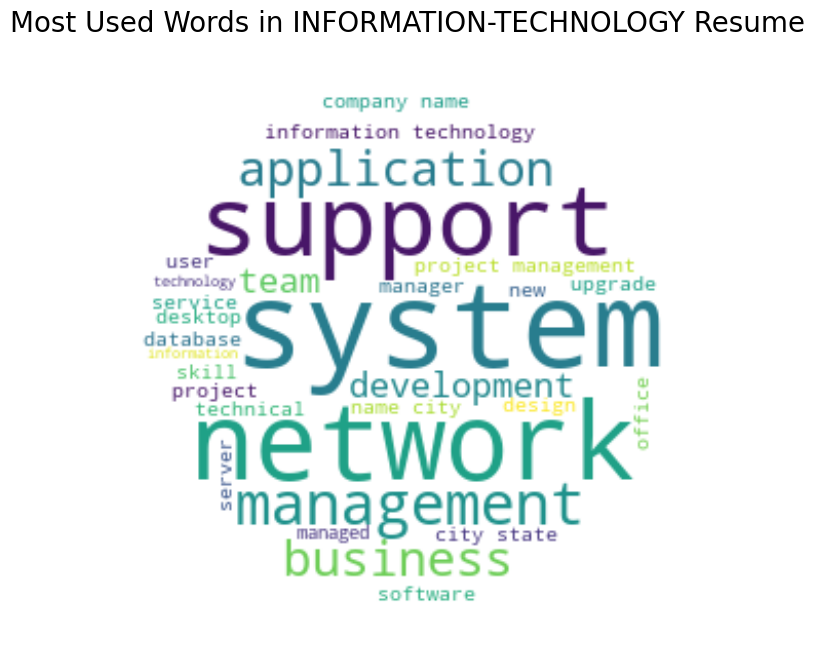

In [38]:
# Most used words
text = ""
for i in data[data["Category"]==job_cat]["Clean_Resume"].values:
    text += i + " "
plt.figure(figsize = (8, 8))
x,y = np.ogrid[:300, :300]
mask = (x-150)**2 + (y-150)**2 > 130**2
mask = 255 * mask.astype(int)

wc = WordCloud(
    width=800,
    height=800,
    background_color="white",
    min_font_size=6,
    repeat=True,
    mask=mask,
)
wc.generate(text)

plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.title(f"Most Used Words in {job_cat} Resume", fontsize=20)

In [39]:
# Entity Recognition
sent = nlp(data["Resume_str"].iloc[0])
displacy.render(sent, style="ent", jupyter=True)

In [44]:
displacy.render(sent[0:10], style="dep", jupyter=True, options={"distance":80})

In [46]:
# user input
colors = {
    "Job-Category": "linear-gradient(90deg, #aa9cfc, #fc9ce7)",
    "SKILL": "linear-gradient(90deg, #9BE15D, #00E3AE)",
    "ORG": "#ffd966",
    "PERSON": "#e06666",
    "GPE": "#9fc5e8",
    "DATE": "#c27ba0",
    "ORDINAL": "#674ea7",
    "PRODUCT": "#f9cb9c",
}
options = {
    "ents": [
        "Job-Category",
        "SKILL",
        "ORG",
        "PERSON",
        "GPE",
        "DATE",
        "ORDINAL",
        "PRODUCT",
    ],
    "colors": colors,
}
input_resume = "Abid Ali Awan Data Scientist I am a certified data scientist professional, who loves building machine learning models and blogs about the latest AI technologies. I am currently testing AI Products at PEC-PITC, which later gets approved for human trials. abidaliawan@tutamail.com +923456855126 Islamabad, Pakistan abidaliawan.me WORK EXPERIENCE Data Scientist Pakistan Innovation and Testing Center - PEC 04/2021 - Present, Islamabad, Pakistan Redesigned data of engineers that were mostly scattered and unavailable. Designed dashboard and data analysis report to help higher management make better decisions. Accessibility of key information has created a new culture of making data-driven decisions. Contact: Ali Raza Asif - darkslayerraza10@gmail.com Data Scientist Freelancing/Kaggle 11/2020 - Present, Islamabad, Pakistan Engineered a healthcare system. Used machine learning to detect some of the common decisions. The project has paved the way for others to use new techniques to get better results. Participated in Kaggle machine learning competitions. Learned new techniques to get a better score and finally got to 1 percent rank. Researcher / Event Organizer CREDIT 02/2017 - 07/2017, Kuala Lumpur, Malaysia Marketing for newly build research lab. Organized technical events and successfully invited the multiple company's CEO for talks. Reduced the gap between industries and educational institutes. Research on new development in the IoT sector. Created research proposal for funding. Investigated the new communication protocol for IoT devices. Contact: Dr. Tan Chye Cheah - dr.chyecheah.t@apu.edu.my EDUCATION MSc in Technology Management Staffordshire University 11/2015 - 04/2017, Postgraduate with Distinction Challenges in Implementing IoT-enabled Smart cities in Malaysia. Bachelors Electrical Telecommunication Engineering COMSATS Institute of Information Technology, Islamabad 08/2010 - 01/2014, CGPA: 3.09 Networking Satellite communications Programming/ Matlab Telecommunication Engineering SKILLS Designing Leadership Media/Marketing R/Python SQL Tableau NLP Data Analysis Machine learning Deep learning Webapp/Cloud Feature Engineering Ensembling Time Series Technology Management ACHIEVEMENTS 98th Hungry Geese Simulation Competition (08/2021) 2nd in Covid-19 vaccinations around the world (07/2021) 8th in Automatic Speech Recognition in WOLOF (06/2021) Top 10 in WiDS Datathon. (03/2021) 40th / 622 in MagNet: Model the Geomagnetic Field Hosted by NOAA (02/2021) 18th in Rock, Paper, Scissors/Designing AI Agent Competition. (02/2021) PROJECTS Goodreads Profile Analysis WebApp (09/2021) Data Analysis Web Scraping XLM Interactive Visualization Contributed in orchest.io (08/2021) Testing and Debuging Technical Article Proposing new was to Improve ML pipelines World Vaccine Update System (06/2021) Used sqlite3 for database Automated system for daily update the Kaggle DB and Analysis Interactive dashboard mRNA-Vaccine-Degradation-Prediction (06/2021) Explore our dataset and then preprocessed sequence, structure, and predicted loop type features Train deep learning GRU model Trip Advisor Data Analysis/ML (04/2021) Preprocessing Data, Exploratory Data analysis, Word clouds. Feature Engineering, Text processing. BiLSTM Model for predicting rating, evaluation, model performance. Jane Street Market Prediction (03/2021) EDA, Feature Engineering, experimenting with hyperparameters. Ensembling: Resnet, NN Embeddings, TF Simple NN model. Using simple MLP pytorch model. Achievements/Tasks Achievements/Tasks Achievements/Tasks Thesis Courses"
sent2 = nlp(input_resume)
displacy.render(sent2, style="ent", jupyter=True, options=options)

In [53]:
# Match score
input_skills="Data Science,Data Analysis,Database,SQL,Machine Learning,tableau"
req_skills = input_skills.lower().split(",")
resume_skills = unique_skills(get_skills(input_resume.lower()))
score = 0
for x in req_skills:
    if x in resume_skills:
        score += 1
req_skills_len = len(req_skills)
match = round(score / req_skills_len *100, 1)
print(f"The current resume is {match}% match to requirements")

The current resume is 66.7% match to requirements


In [54]:
# Topic modeling
docs = data["Clean_Resume"].values
dictionary = corpora.Dictionary(d.split() for d in docs)
bow = [dictionary.doc2bow(d.split()) for d in docs]
lda = gensim.models.ldamodel.LdaModel
num_topics = 4
ldamodel = lda(
    bow, 
    num_topics=num_topics, 
    id2word=dictionary, 
    passes=50, 
    minimum_probability=0
)
ldamodel.print_topics(num_topics=num_topics)

[(0,
  '0.014*"customer" + 0.013*"state" + 0.012*"city" + 0.010*"company" + 0.009*"name" + 0.008*"service" + 0.008*"skill" + 0.006*"student" + 0.005*"sale" + 0.004*"work"'),
 (1,
  '0.011*"business" + 0.011*"company" + 0.010*"management" + 0.010*"state" + 0.009*"city" + 0.009*"sale" + 0.008*"project" + 0.007*"name" + 0.006*"account" + 0.006*"team"'),
 (2,
  '0.010*"state" + 0.007*"city" + 0.007*"employee" + 0.006*"company" + 0.006*"program" + 0.005*"name" + 0.005*"skill" + 0.004*"training" + 0.004*"education" + 0.004*"new"'),
 (3,
  '0.014*"system" + 0.009*"project" + 0.007*"network" + 0.007*"support" + 0.007*"software" + 0.006*"company" + 0.006*"management" + 0.006*"server" + 0.006*"technical" + 0.005*"city"')]

In [56]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(ldamodel, bow, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.010213 -0.082965       1        1  47.412199
0     -0.053898 -0.064733       2        1  33.771149
3      0.145801  0.050181       3        1  12.955327
2     -0.102117  0.097517       4        1   5.861324, topic_info=            Term         Freq        Total Category  logprob  loglift
351       system   536.000000   536.000000  Default  30.0000  30.0000
275      project   641.000000   641.000000  Default  29.0000  29.0000
340        state  1254.000000  1254.000000  Default  28.0000  28.0000
135     employee   271.000000   271.000000  Default  27.0000  27.0000
1373     network   152.000000   152.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
308     research    18.438807   146.405520   Topic4  -5.9573   0.7649
955        event    19.164456   207.445120   Topic4  -5.9187   0.4550
147   experience    20.461587   446.053411   Topic4  -5.8532  -0.2451
533     relation    17.823687   120.714310   Topic4  -5.9912   0.9239
338        staff    17.915532   291.691205   Topic4  -5.9861   0.0468

[343 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1         1  0.909106      000
1         2  0.083733      000
2244      3  0.939058      11g
5008      4  0.793192       19
15        1  0.886824  account
...     ...       ...      ...
384       1  0.673235     year
384       2  0.230733     year
384       3  0.060054     year
384       4  0.037929     year
6261      4  0.904960     yoga

[659 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 3])

TODO:
- go through other notebooks [here](https://deepnote.com/@abid/spaCy-Resume-Analysis-81ba1e4b-7fa8-45fe-ac7a-0b7bf3da7826)
- finetune this into a useful resume parser usecase